In [1]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import numpy as np
import pandas as pd

In [2]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [3]:
municipios = geopandas.read_file('municipios/Municipios_IBGE.shp')

In [4]:
municipios.head()

,MSLINK,MAPID,AREA_1,PERIMETRO_,NOME,SEDE,LATITUDESE,LONGITUDES,AREA_TOT_G,Cod_ibge,Label_N,geometry
0,4985,99,118.280,61.626,HERVEIRAS,1,-29.407,-52.653,118.280,4309571,Herveiras,"POLYGON ((-52.77319 -29.44486, -52.77602 -29.4..."
1,4986,99,228.849,81.715,HORIZONTINA,1,-27.626,-54.308,228.849,4309605,Horizontina,"POLYGON ((-54.39910 -27.57012, -54.38675 -27.5..."
2,4987,99,822.943,184.883,HULHA NEGRA,1,-31.404,-53.869,822.943,4309654,Hulha Negra,"POLYGON ((-53.98933 -31.55208, -53.99221 -31.5..."
3,4988,99,135.246,70.392,HUMAITA,1,-27.563,-53.974,135.246,4309704,Humaitá,"POLYGON ((-54.07227 -27.57674, -54.06089 -27.5..."
4,4989,99,193.109,70.655,IBARAMA,1,-29.419,-53.135,193.109,4309753,Ibarama,"POLYGON ((-53.26582 -29.44975, -53.26701 -29.4..."


In [5]:
grupos = {'Materiais para construção civil':['AREIA', 'AREIA DE FUNDIÇÃO', 'AREIA QUARTZOSA', 'AREIA COMUM', 'AREIA FLUVIAL', 'ARENITO', 'ARGILA', 'ARGILA REFRATÁRIA', 'ARGILITO', 'BASALTO', 'BASALTO P/ BRITA', 'BENTONITA', 'CALCÁRIO', 'CALCÁRIO CALCÍTICO', 'CASCALHO', 'DIABÁSIO', 'DIABÁSIO P/ BRITA', 'GABRO', 'GNAISSE', 'GRANITO', 'QUARTZITO', 'RIÓLITO', 'SAIBRO'],
'Insumos agrícolas': ['CALCÁRIO', 'CALCÁRIO DOLOMÍTICO', 'CALCÁRIO CALCÍTICO', 'CALCÁRIO CONCHÍFERO', 'CONCHAS CALCÁRIAS', 'PEDRA CALCÁRIA', 'CAULIM', 'DOLOMITO', 'FOSFATO', 'TALCO'],
'Recursos energéticos': ['ANTRACITO', 'ARENITO BETUMINOSO', 'CARVÃO MINERAL', 'FOLHELHO BETUMINOSO', 'FOLHELHO PIROBETUMINOSO', 'LINHITO', 'ROCHA BETUMINOSA', 'SAPROPELITO', 'TURFA'],
'Minerais metálicos': ['CASSITERITA', 'CHUMBO', 'COBRE', 'FERRO', 'ILMENITA', 'LIMONITA', 'MINÉRIO DE CHUMBO', 'MINÉRIO DE COBRE', 'MINÉRIO DE OURO', 'MINÉRIO DE TITÂNIO', 'MINÉRIO DE ZINCO', 'MOLIBDÊNIO', 'OURO', 'PRATA', 'TANTALITA', 'TITÂNIO'],
'Indústria cerâmica': ['ARGILA', 'CALCÁRIO', 'ARGILA REFRATÁRIA', 'ARGILA VERMELHA', 'ARGILA CAULÍNICA', 'ARGILA P/CER. VERMELH', 'ARGILITO', 'BENTONITA', 'CAULIM', 'FILITO'],
'Rochas ornamentais': ['ANORTOSITO', 'ARENITO', 'BASALTO', 'BASALTO P/ REVESTIMENTO', 'DIABÁSIO', 'GRANITO', 'GRANITO ORNAMENTAL', 'MÁMORE', 'QUARTZITO', 'RIÓLITO', 'SIENITO'],  
'Pedras preciosas':['ÁGATA', 'ÁGUA MARINHA', 'AMETISTA', 'CALCEDÔNIA', 'CITRINO', 'GEMA', 'OPALA', 'QUARTZO'],
'Águas minerais': ['ÁGUA MINERAL ALC. BIC', 'ÁGUA MINERAL', 'ÁGUA POTÁVEL DE MESA']
         }

In [6]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

In [7]:
x_pts = []
y_pts = []

geometrias = municipios['geometry'].to_crs("EPSG:4326")
for g in geometrias:
    cent = g.centroid
    x_pts.append(cent.x)
    y_pts.append(cent.y)

In [8]:
producao = pd.read_csv('dados_producao.csv', index_col=0)

In [9]:
producao.head()

,ARGILA,CHUMBO,CALCÁRIO,CARVÃO,ÁGUA MINERAL ALC. BIC,ÁGUA MINERAL,AREIA,COBRE,TALCO,CAULIM,...,DACITO,FONÓLITO,FERRO,ÁGUA POTÁVEL DE MESA,CITRINO,BARITA,DIORITO,FILITO,ARGILA P/CER. VERMELH,COBRE NATIVO
NOME,,,,,,,,,,,,,,,,,,,,,
HERVEIRAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HORIZONTINA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HULHA NEGRA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.554997,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HUMAITA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IBARAMA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
minerais = producao.columns[1:]

In [11]:
import numpy as np

In [12]:
valores = producao.values.flatten()
hist, bin_edges = np.histogram(valores, bins=5)
bin_edges

array([  0.        ,  83.86214135, 167.72428269, 251.58642404,
       335.44856539, 419.31070674])

In [13]:
norm = 6

In [14]:
def which_bin(v, bin_edges, n_bins=5, norm=1):
    size = None
    if v == 0:
        size = 0
    else:
        for i in range(n_bins):
            limits = bin_edges[i:i+2]
            if v >= limits[0] and v <= limits[1]:
                size=np.mean(limits)
    return size * norm

In [15]:
def create_legend(bin_edges, n_bins=5, norm=1):
    legend = []
    sizes = []
    for i in range(n_bins):
        limits = bin_edges[i:i+2]
        s = np.mean(limits)
        l = 'de {} a {}'.format(int(limits[0]), int(limits[1]))
        legend.append(l)
        sizes.append(s)
    return legend, np.array(sizes) * norm

In [16]:
l, ss = create_legend(bin_edges, n_bins=5, norm=norm)

In [17]:
l, ss

(['de 0 a 83', 'de 83 a 167', 'de 167 a 251', 'de 251 a 335', 'de 335 a 419'],
 array([ 251.58642404,  754.75927213, 1257.93212021, 1761.1049683 ,
        2264.27781638]))

<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False aft

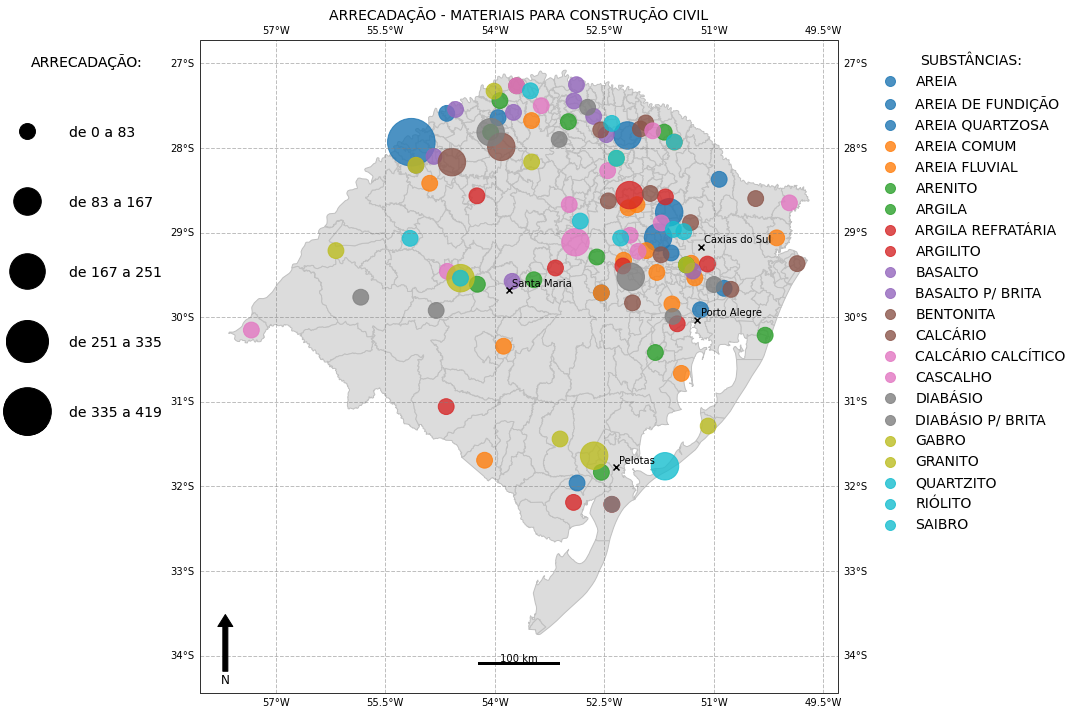

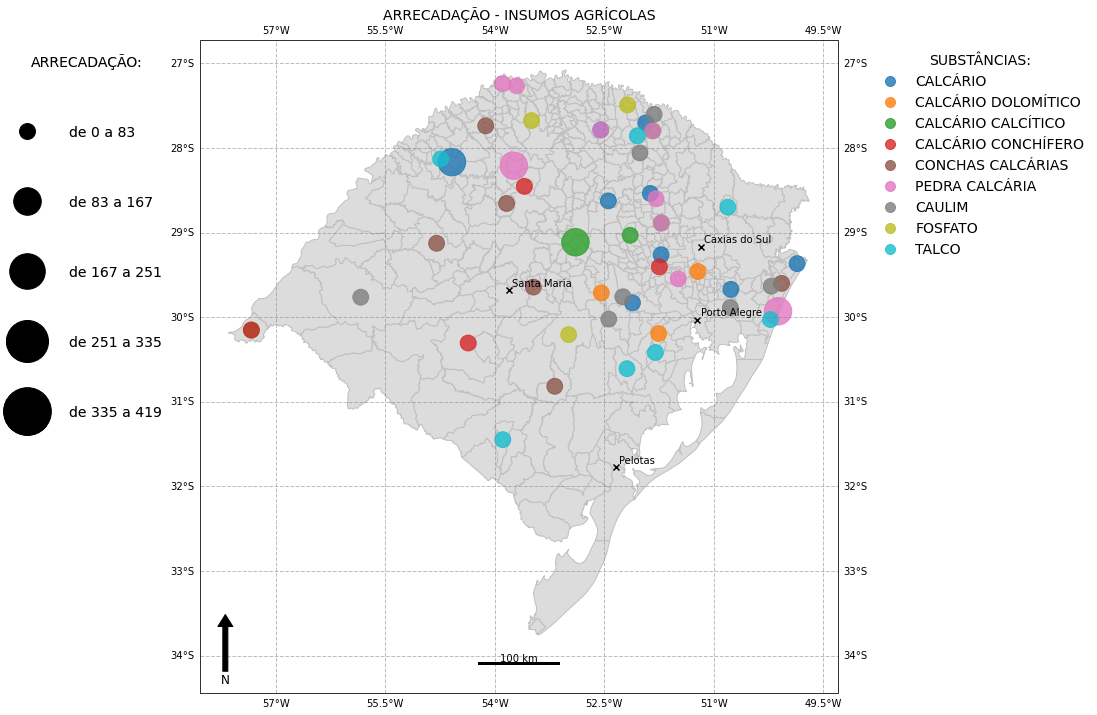

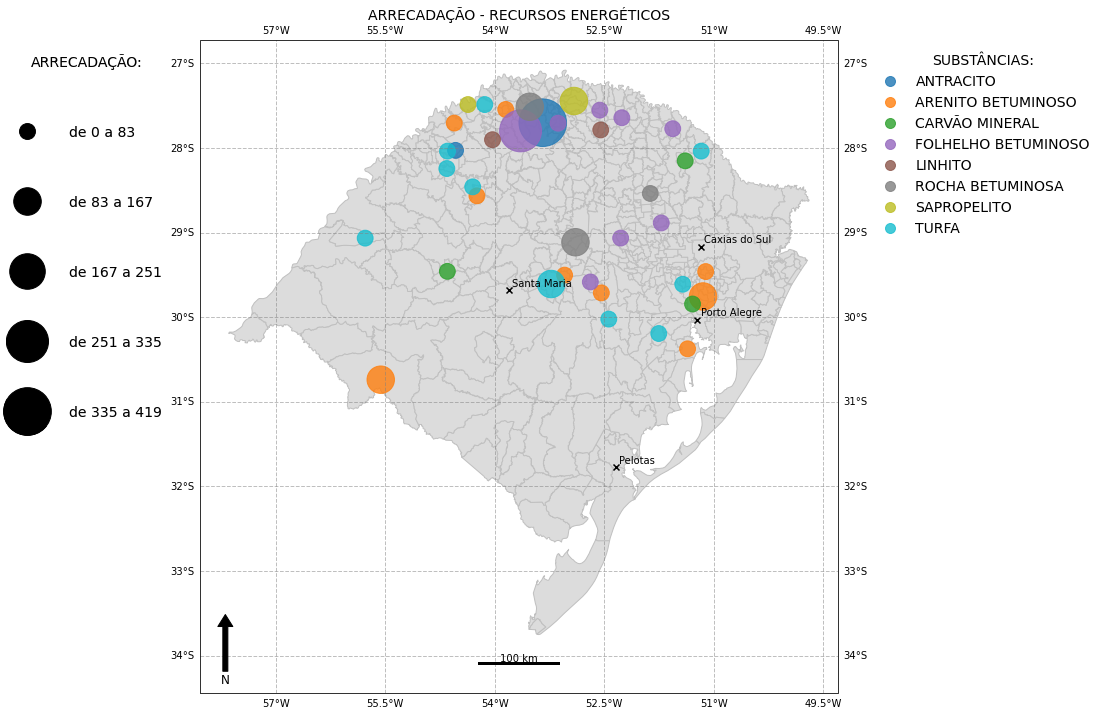

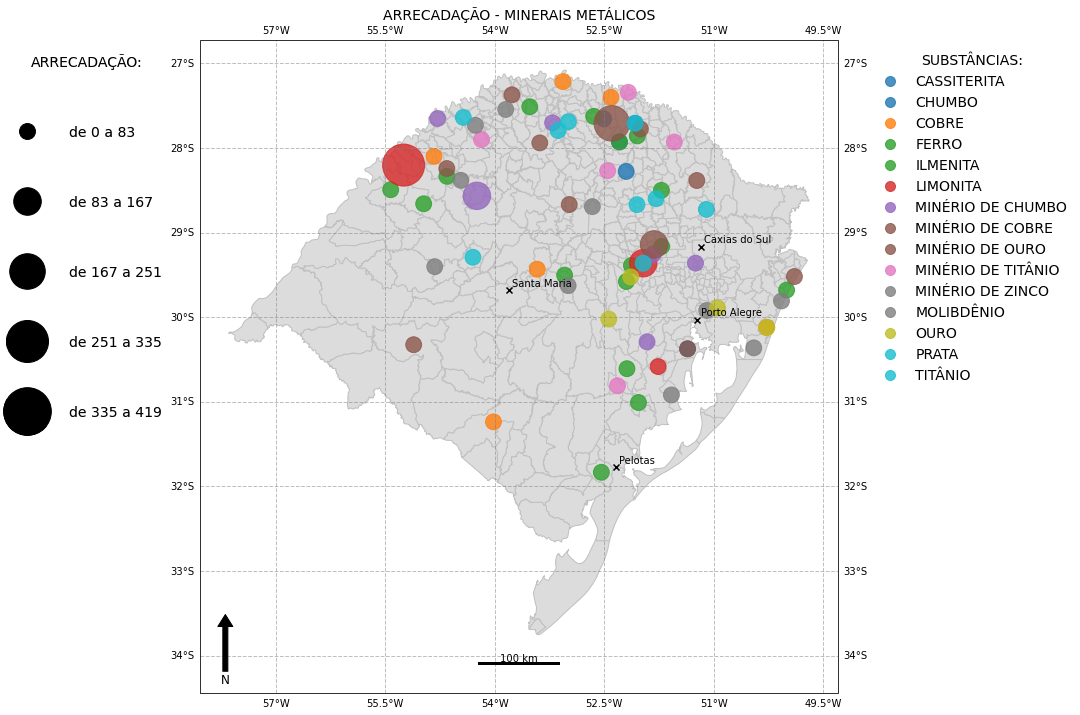

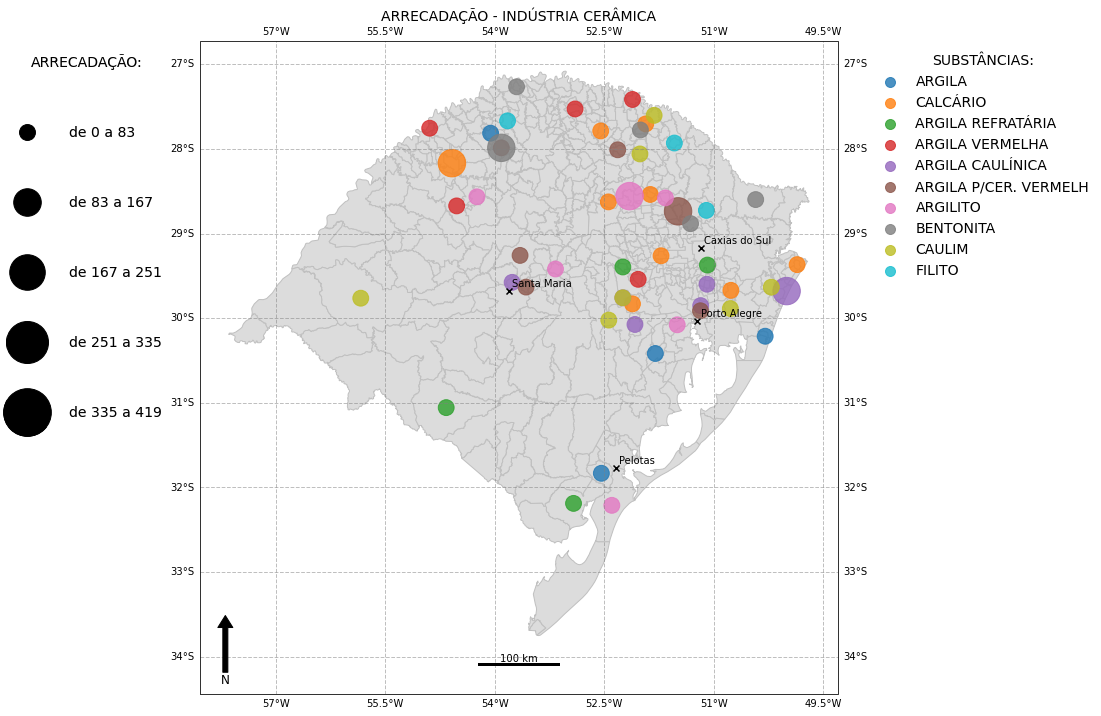

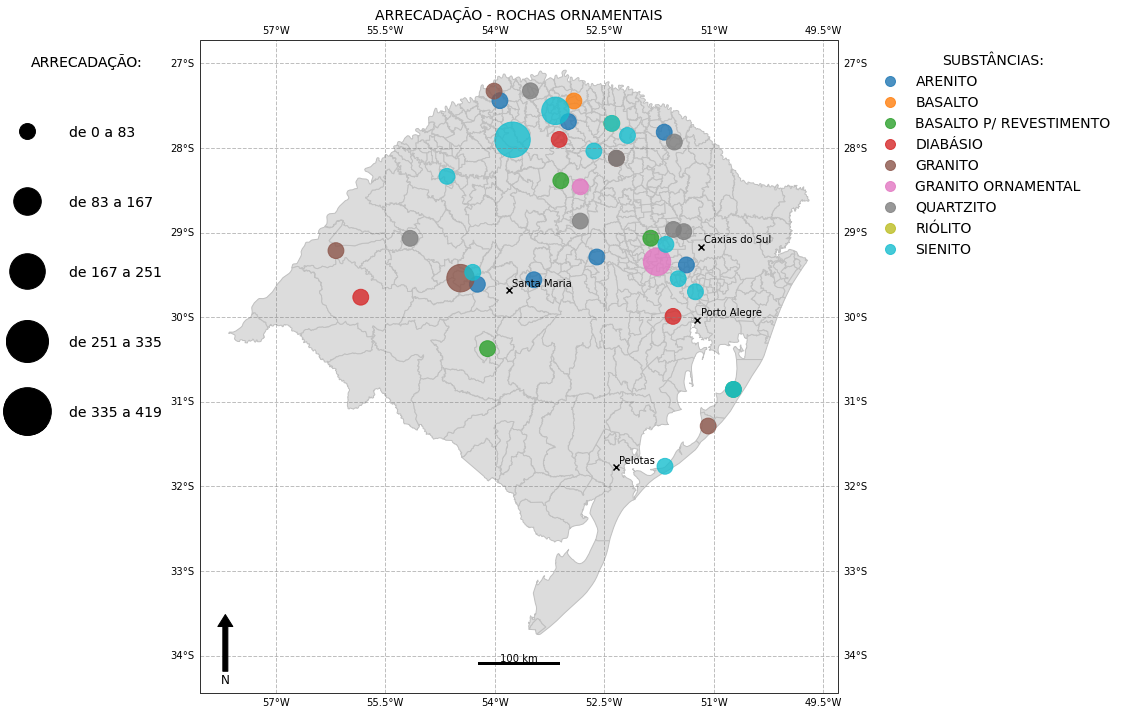

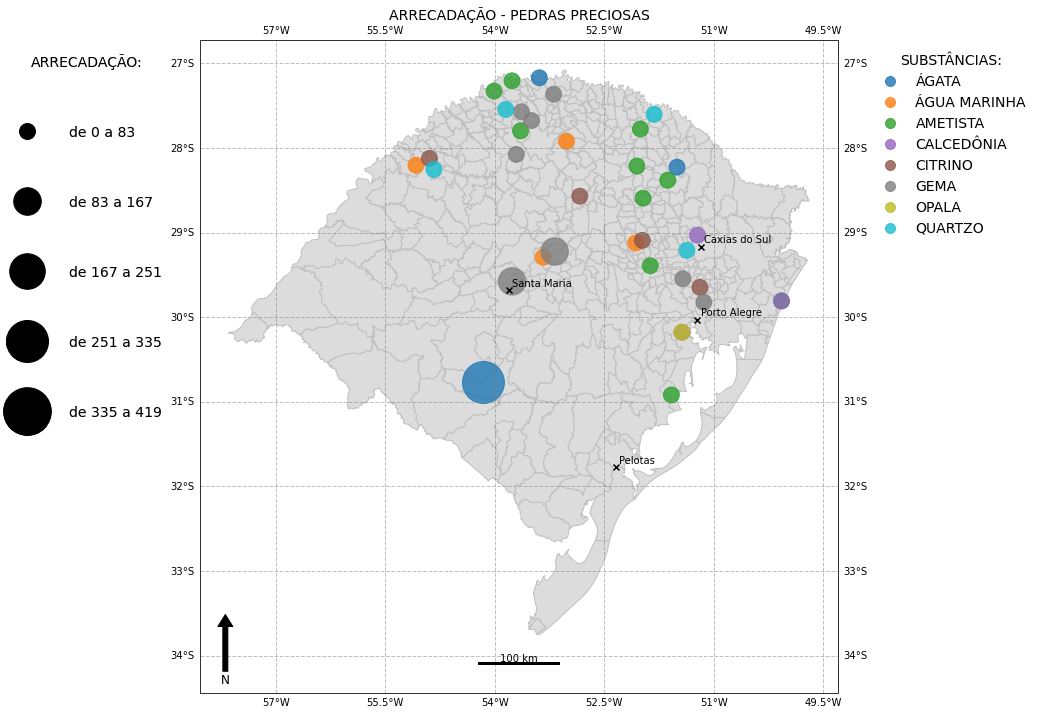

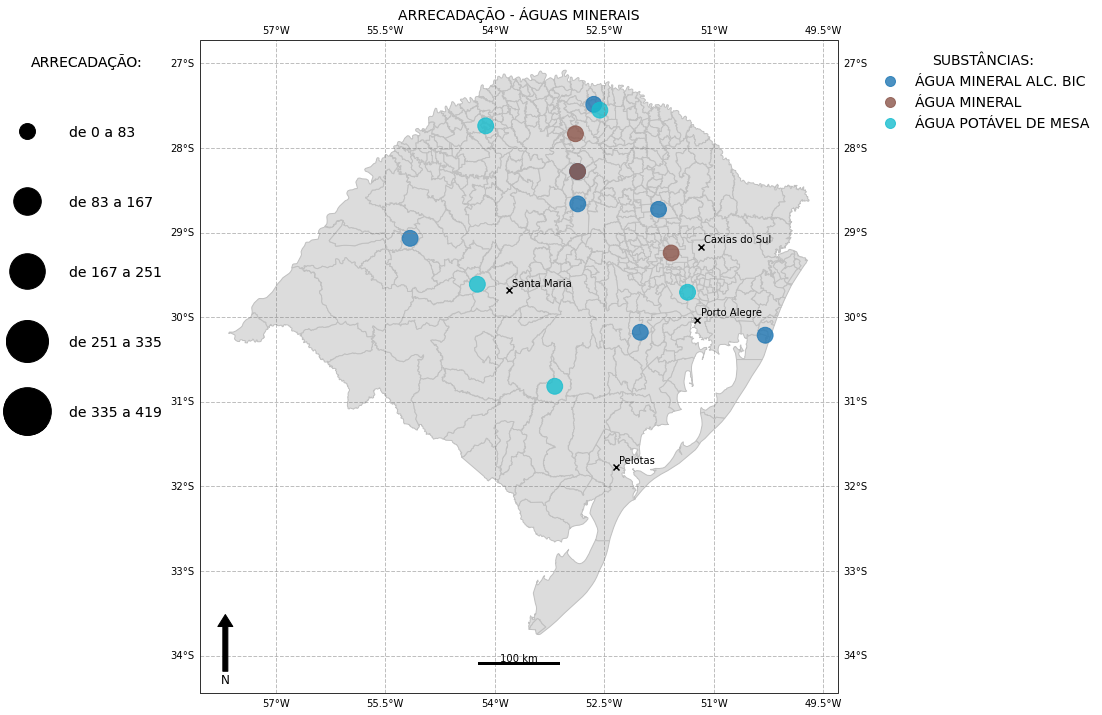

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for grupo in grupos:
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
    municipios.plot(ax=ax, color='gainsboro', edgecolor='silver')
    
    colunas = grupos[grupo]
    for i in colunas:
        if i not in producao.columns:
            colunas.remove(i)
    
    filtrado = producao[colunas]
    
    #colors
    colormap = plt.cm.tab10
    colors = [colormap(i) for i in np.linspace(0, 1, len(colunas))]
    ax.set_prop_cycle('color', colors)
    
    for mineral in filtrado.columns:    
        s = [which_bin(v=i, bin_edges=bin_edges, n_bins=5, norm=norm) for i in producao[mineral]]
        scatter = plt.scatter(x_pts, y_pts, alpha=0.8, s=s, label=mineral)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False

    x, y, arrow_length = 0.04, 0.12, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
    arrowprops=dict(facecolor='black', width=5, headwidth=15),
    ha='center', va='center', fontsize=12,
    xycoords=ax.transAxes)

    scale_bar(ax, 100, location=(0.5,0.01))
    
    test = plt.scatter(x=np.ones(len(ss))*-54, y=np.ones(len(ss))*-30, s=ss, alpha=0)
    handles, labels = test.legend_elements(prop="sizes", alpha=0.6)
    labels = l
    kw = dict(prop="sizes")
    
    lgd1 = ax.legend(bbox_to_anchor=(1.04, 1), edgecolor = 'white', fontsize='14', title='SUBSTÂNCIAS:', title_fontsize='14', loc='upper left')
    for handle in lgd1.legendHandles:
        handle.set_sizes([100.0])
    lgd2 = ax.legend(handles, labels, labelspacing=4, handletextpad=2 , bbox_to_anchor=(-0.04, 1), edgecolor = 'white', fontsize='14', title='ARRECADAÇÃO:', title_fontsize='14', loc='upper right')
    nl = []
    for i, handle in enumerate(lgd2.legendHandles):
        handle._legmarker.set_alpha(1)

    plt.gca().add_artist(lgd1)
    plt.gca().add_artist(lgd2)
    
    plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05)

    ax.set_title('ARRECADAÇÃO - {}'.format(grupo.upper()), loc='center', fontsize='14')
    nome = grupo.upper()
    plt.savefig('imagens/arrecadacao/'+nome+".png", bbox_inches='tight', facecolor='white', dpi = 300, bbox_extra_artists=(lgd1,lgd2, ax))